## Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Нам предстоит решить задачу машинного обучения, направленную на автоматизацию бизнес процессов: построить модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

## 1. Знакомство с данными, базовый анализ и расширение данных

Заранее импортируем модули, которые понадобятся для решения задачи:

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [19]:
taxi_data = pd.read_csv("F:\IDE\SkillFactory\Проекты\Project-5\\train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах

Для начала проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

Для начала посмотрим на временные рамки, в которых мы работаем с данными.

In [20]:
# Переводим данные в столбце pickup_datetime в формат datetime:
taxi_data['pickup_datetime'] = pd.to_datetime(
    taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S'
    )
taxi_data['pickup_datetime'].describe()

count                          1458644
mean     2016-04-01 10:10:24.940037120
min                2016-01-01 00:00:17
25%      2016-02-17 16:46:04.249999872
50%                2016-04-01 17:19:40
75%      2016-05-15 03:56:08.750000128
max                2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

Таким образом, мы располагаем данными за период с 1 января по 30 июня 2014 г.

Посмотрим на пропуски.

In [21]:
taxi_data.isnull().sum().sum()

0

Пропусков в наших данных нет.

Посмотрим на статистические характеристики некоторых признаков.

In [22]:
print(f"Всего уникальных таксопарков: {taxi_data['vendor_id'].nunique()}")
print(f"Максимальное число пассажиров: {taxi_data['passenger_count'].max()}")
print(f"Средняя длительность поездки: \
    {round(taxi_data['trip_duration'].mean())}, \
        медианная - {round(taxi_data['trip_duration'].median())}")
print(f"Минимальная длительность поездки: \
    {taxi_data['trip_duration'].min()}, \
        максимальная - {taxi_data['trip_duration'].max()}")

Всего уникальных таксопарков: 2
Максимальное число пассажиров: 9
Средняя длительность поездки:     959,         медианная - 662
Минимальная длительность поездки:     1,         максимальная - 3526282


Расширим исходный набор данных новыми признаками.

Реализуем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

In [23]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()
    return df

taxi_data = add_datetime_features(taxi_data)

# Посмотрим, сколько поездок совершается в день:
print(f"В среднем в день совершается {round(taxi_data.groupby(by='pickup_date').count()['id'].mean())} поездок")

В среднем в день совершается 8015 поездок


От того, является ли день праздничным, часто зависит ситуация на дорогах. Большое количество автомобилей создаёт пробки и потенциально увеличивает длительность совершаемой на такси поездки. Добавим в наш датасет информацию о том, является ли день праздничным. Для этого воспользуемся таблицей с данными о праздничных днях в США.

Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).

Проверим нашу гипотезу о том, что поездки в будние дни длятся дольше, чем в праздничные из-за различной ситуации на дорогах.

In [24]:
# Загружаем таблицу с данными о выходных и праздничных дня в США:
holiday_data = pd.read_csv('F:\IDE\SkillFactory\Проекты\Project-5\holiday_data.csv', sep=';')

# Фукнция, добавляющая столбец pickup_holiday:
def add_holiday_features(df1, df2):
    df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d').dt.date
    df1['pickup_holiday'] = df1['pickup_date'].apply(
        lambda x: 1 if x in df2['date'].to_list() else 0
        )
    return df1

# Реализуем функцию на нашем датасете:
taxi_data = add_holiday_features(taxi_data, holiday_data)

# Посмотрим на медианную длительность поездки в праздничные дни:
print(f"Mедианная длительность поездки на такси в праздничные дни равна \
    {taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median()} сек.")
print(f"Mедианная длительность поездки на такси в будние дни равна \
    {taxi_data[taxi_data['pickup_holiday'] == 0]['trip_duration'].median()} сек.")

Mедианная длительность поездки на такси в праздничные дни равна     585.0 сек.
Mедианная длительность поездки на такси в будние дни равна     665.0 сек.


Как видим, наша гипотеза подтвердилась: медианная продолжительность поездки в будние дни на 12% больше, чем в праздничные.

В данных есть столбцы, содержащие информацию о широте и долготе. Из них можно извлечь очень много полезной информации. Например, зная широту и долготу начальной и конечной точек маршрута, мы можем воспользоваться OSRM API, открытым бесплатным ресурсом, который активно используется во многих сервисах, предполагающих построение кратчайшего маршрута. Он позволяет построить оптимальный кусочно-линейный путь из точки А в точку B, а также узнать его примерную длительность и длину.

Мы воспользуемся выгрузкой из данных OSRM API, которая содержит следуюущие столбцы:
* id — идентификатор поездки;
* total_distance — кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* total_travel_time — наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* number_of_steps — количество дискретных шагов, которые должен выполнить водитель (поворот налево/поворот направо/ехать прямо и т. д.).

Реализуем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

In [25]:
osrm_data = pd.read_csv('F:\IDE\SkillFactory\Проекты\Project-5\osrm_data_train.csv')

def add_osrm_features(df1, df2):
    merged = df2[['total_distance', 'total_travel_time', 'number_of_steps', 'id']]
    df1 = df1.merge(merged, on='id', how='left')
    return df1

taxi_data = add_osrm_features(taxi_data, osrm_data)

taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0,1614.9,140.1,5.0


С помощью географических характеристик можно извлечь ещё немного информации. Если рассматривать Землю как сферу, то, зная широту и долготу начальной и конечной точек маршрута, можно вычислить географическое расстояние между точками на сфере, а также узнать направление движения автомобиля.

Введём в наш анализ расстояние по формуле гаверсинуса.

Данная формула определяет кратчайшее расстояние между двумя точками на сфере, если известны широта и долгота каждой из точек. Геометрически это длина кратчайшей дуги, связывающей точки на сфере.

Пусть есть две точки с географическими координатами $x_1 = (\varphi_1, \lambda_1)$ и $x_2 = (\varphi_2, \lambda_2)$, где

* $\varphi_1$ и $\lambda_1$ — широта (latitude) и долгота (longitude) первой точки маршрута (в радианах);
* $\varphi_2$ и $\lambda_2$ — широта (latitude) и долгота (longitude) второй точки маршрута (в радианах).
Тогда расстояние по формуле гаверсинуса (в километрах) определяется как:
$$h(x_1,x_2) = 2R \ arcsin (\sqrt{sin^2 (\frac{\varphi_2 - \varphi_1}{2}) + cos(\varphi_1) cos(\varphi_2) sin (\frac{\lambda_2 - \lambda_1}{2})}),$$
где $R$ — радиус земли (6371 км), $h$ — расстояние между двумя точками на сфере (в километрах).

Разница между OSRM и гаверсинусом заключается в том, что OSRM - это расстояние по дорожным меткам, а гаверсинус - евклидово расстояние между двумя точками.

Далее, зная начальную и конечную точку маршрута, мы можем вычислить направление движения автомобиля (угол пеленга) по формуле:
$$\alpha = arctg (\frac{sin (\lambda_2 - \lambda_1) cos (\varphi_2)}{cos (\varphi_1) sin (\varphi_2) - sin (\varphi_1) cos (\varphi_2) cos (\lambda_2 - \lambda_1)}),$$
где $\alpha$ — угол направления движения от первой точки ко второй (может измеряться как в радианах, так и в градусах).

Напишем формулы для определения гаверсинуса и угла направления движения (в градусах).

In [26]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние по формуле гаверсинуса между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

In [27]:
def add_geographical_features(df):

    df['haversine_distance'] = get_haversine_distance(df['pickup_latitude'],
                                                        df['pickup_longitude'],
                                                        df['dropoff_latitude'],
                                                        df['dropoff_longitude'])

    df['direction'] = get_angle_direction(df['pickup_latitude'],
                                                df['pickup_longitude'],
                                                df['dropoff_latitude'],
                                                df['dropoff_longitude'])
    
    return df

taxi_data = add_geographical_features(taxi_data)

taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0,2009.1,164.9,5.0,1.498521,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0,2513.2,332.0,6.0,1.805507,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0,6.385098,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0,1.485498,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0,1614.9,140.1,5.0,1.188588,179.473585


Ещё одна важная манипуляция с географическими данными, которую мы можем сделать, — это применение кластеризации по географическим координатам. Идея заключается в том, чтобы сгруппировать все поездки в зависимости от координат начала и конца поездки с помощью методов кластеризации, тем самым добавив информацию о районах, в которых находятся точки старта и конца поездки.

Гипотеза состоит в том, что длительность поездки будет зависеть от того, к какому географическому кластеру будет принадлежать поездка.

В качестве метода кластеризации воспользуемся алгоритмом K-Means. Возьмём десять кластеров и обучим его на данных, сформированных из широты и долготы всех точек начала и конца поездок.

In [28]:
def add_cluster_features(df):

    # создаем обучающую выборку из географических координат всех точек
    coords = np.hstack((df[['pickup_latitude', 'pickup_longitude']],
                        df[['dropoff_latitude', 'dropoff_longitude']]))
    # обучаем алгоритм кластеризации
    kmeans = cluster.KMeans(n_clusters=10, random_state=42)
    kmeans.fit(coords)

    # Добавляем столбец с номером кластера
    df['geo_cluster'] = kmeans.predict(coords)
    
    return df

taxi_data = add_cluster_features(taxi_data)

taxi_data.head()

c:\Users\Олег\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,17,Monday,0,2009.1,164.9,5.0,1.498521,99.970196,9
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,0,Sunday,0,2513.2,332.0,6.0,1.805507,-117.153768,4
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0,6.385098,-159.680165,4
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0,1.485498,-172.737700,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,13,Saturday,0,1614.9,140.1,5.0,1.188588,179.473585,9


Другим важным фактором, потенциально влияющим на дорожное движение, является погода. Так, например, логично предположить, что снег и дождь могут затруднять движение и увеличивать время поездки.

Воспользуемся датасетом weather_data.csv, содержащим информацию о погодных условиях в Нью-Йорке. Нас будут интересовать только следующие столбцы:

* time — дата измерения (с интервалом в час);
* temperature — температура;
* visibility — видимость;
* wind speed — средняя скорость ветра;
* precip — количество осадков;
* events — погодные явления: Rain — дождь, Snow — снег, Fog — туман, None — отсутствие погодных явлений.

Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

In [29]:
weather_data = pd.read_csv('F:\IDE\SkillFactory\Проекты\Project-5\weather_data.csv')

def add_weather_features(df1, df2):
    df2 = df2[['temperature', 'visibility', 'wind speed', 'precip', 'events', 'date', 'hour']]
    df2['pickup_date'] = pd.to_datetime(df2['date']).dt.date
    df2['pickup_hour'] = df2['hour']
    df2.drop(['date', 'hour'], axis=1, inplace=True)
    
    df1 = df1.merge(df2, on=['pickup_date', 'pickup_hour'], how='left')
    
    return df1

taxi_data = add_weather_features(taxi_data, weather_data)

taxi_data.head()

C:\Users\Олег\AppData\Local\Temp\ipykernel_11992\1435442443.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['pickup_date'] = pd.to_datetime(df2['date']).dt.date
C:\Users\Олег\AppData\Local\Temp\ipykernel_11992\1435442443.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['pickup_hour'] = df2['hour']
C:\Users\Олег\AppData\Local\Temp\ipykernel_11992\1435442443.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,NaN
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,NaN
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,NaN
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,NaN
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,NaN


В результате добавления новой информации у нас появились пропущенные значения в данных.

In [30]:
# Смотрим на пропуски в данных
taxi_data.isnull().sum()

id                          0
vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
store_and_fwd_flag          0
trip_duration               0
pickup_date                 0
pickup_hour                 0
pickup_day_of_week          0
pickup_holiday              0
total_distance              1
total_travel_time           1
number_of_steps             1
haversine_distance          0
direction                   0
geo_cluster                 0
temperature             12032
visibility              12032
wind speed              12032
precip                  12032
events                1387217
dtype: int64

Пропуски в столбцах с погодными условиями (temperature, visibility, wind speed, precip) заполним медианным значением температуры, видимости, скорости ветра и количества осадков в зависимости от даты начала поездки. Для этого сгруппируем данные по столбцу pickup_date и рассчитаем медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполним пропуски.

Пропуски в столбце events заполним строкой 'None' — символом отсутствия погодных явлений (снега/дождя/тумана).

Пропуски в столбцах с информацией из OSRM API (total_distance, total_travel_time и number_of_steps) заполним медианным значением по столбцам.

Реализуем функцию fill_null_weather_data(), которая принимает на вход таблицу с данными о поездках и заполняет данные в столбцах по описанным выше формулам.

In [31]:
def fill_null_weather_data(df):

    df['temperature'] = df['temperature'].fillna(df.groupby('pickup_date')['temperature'].transform('median'))
    df['visibility'] = df['visibility'].fillna(df.groupby('pickup_date')['visibility'].transform('median'))
    df['wind speed'] = df['wind speed'].fillna(df.groupby('pickup_date')['wind speed'].transform('median'))
    df['precip'] = df['precip'].fillna(df.groupby('pickup_date')['precip'].transform('median'))
    df['total_distance'] = df['total_distance'].fillna(df.groupby('pickup_date')['total_distance'].transform('median'))
    df['total_travel_time'] = df['total_travel_time'].fillna(df.groupby('pickup_date')['total_travel_time'].transform('median'))
    df['number_of_steps'] = df['number_of_steps'].fillna(df.groupby('pickup_date')['number_of_steps'].transform('median'))
    df['events'] = df['events'].fillna('None')
    
    return df

taxi_data = fill_null_weather_data(taxi_data)
# Убедимся, что пропусков не осталось
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        0
total_travel_time     0
number_of_steps       0
haversine_distance    0
direction             0
geo_cluster           0
temperature           0
visibility            0
wind speed            0
precip                0
events                0
dtype: int64

Мы избавились от пропусков.

Теперь найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Будем считать выбросом поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Мы будем считать выбросами только последнюю группу.

Чтобы обнаружить выбросы, можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:

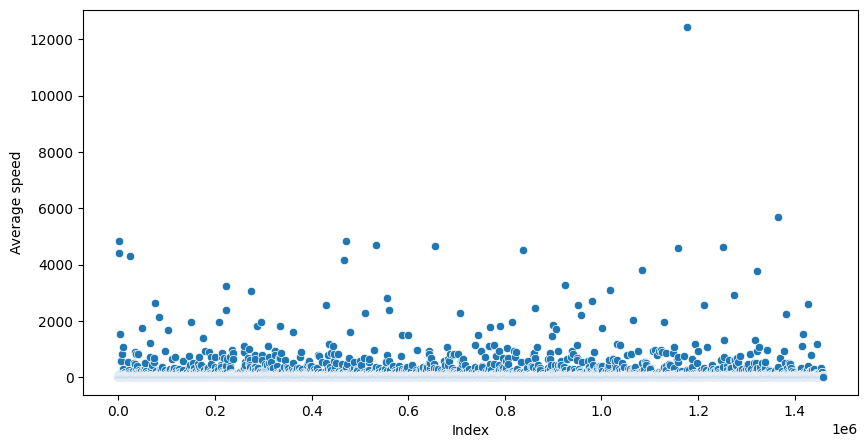

In [32]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 

Найдём поездки, длительность которых превышает 24 часа, а также поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч, и удалим их из набора данных.

In [33]:
taxi_data['avg_speed'] = avg_speed

taxi_data = taxi_data[taxi_data['avg_speed'] <= 300]
taxi_data = taxi_data[taxi_data['trip_duration'] <= 86400]

taxi_data.drop(['avg_speed'], axis=1, inplace=True)

# Посмотрим, сколько записей осталось в наборе данных
taxi_data.shape[0]

1458233

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими исследование.

Начинаем с целевого признака. Поскольку основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе, целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.

In [34]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
С помощью теста Д’Агостино проверим, является ли распределение данных в целевой переменной нормальным. За уровнень значимости $\alpha$ примем 0.05. 

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


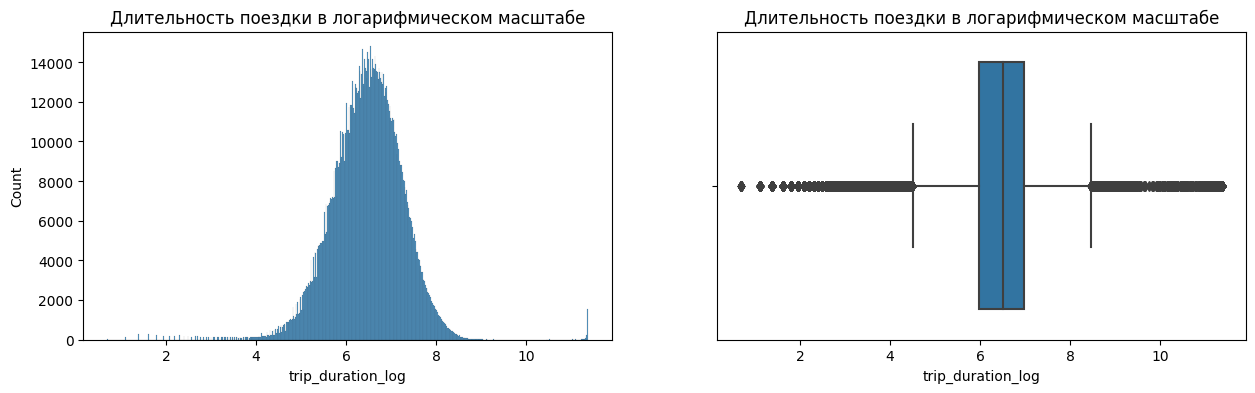

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=taxi_data, x=taxi_data['trip_duration_log'], ax=axes[0]);
histplot.set_title('Длительность поездки в логарифмическом масштабе');
boxplot = sns.boxplot(data=taxi_data, x=taxi_data['trip_duration_log'], ax=axes[1]);
boxplot.set_title('Длительность поездки в логарифмическом масштабе');

# задаём уровень значимости
alpha = 0.05 

# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
        
# проводим тест д'Агостино:
result = stats.normaltest(taxi_data['trip_duration_log'])
decision_normality(result[1])

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id).

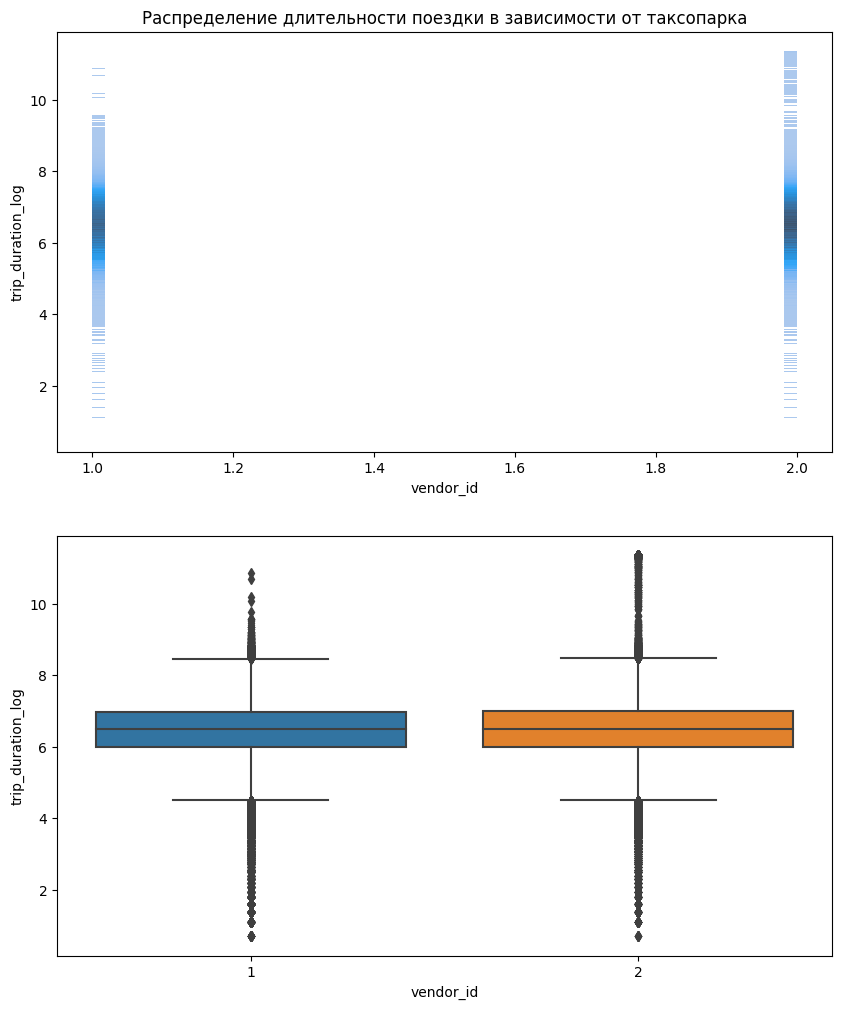

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
histplot = sns.histplot(data=taxi_data, x=taxi_data['vendor_id'], y=taxi_data['trip_duration_log'], ax=axes[0]);
histplot.set_title('Распределение длительности поездки в зависимости от таксопарка');
boxplot = sns.boxplot(data=taxi_data, x=taxi_data['vendor_id'], y=taxi_data['trip_duration_log'], ax=axes[1]);

Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки.

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

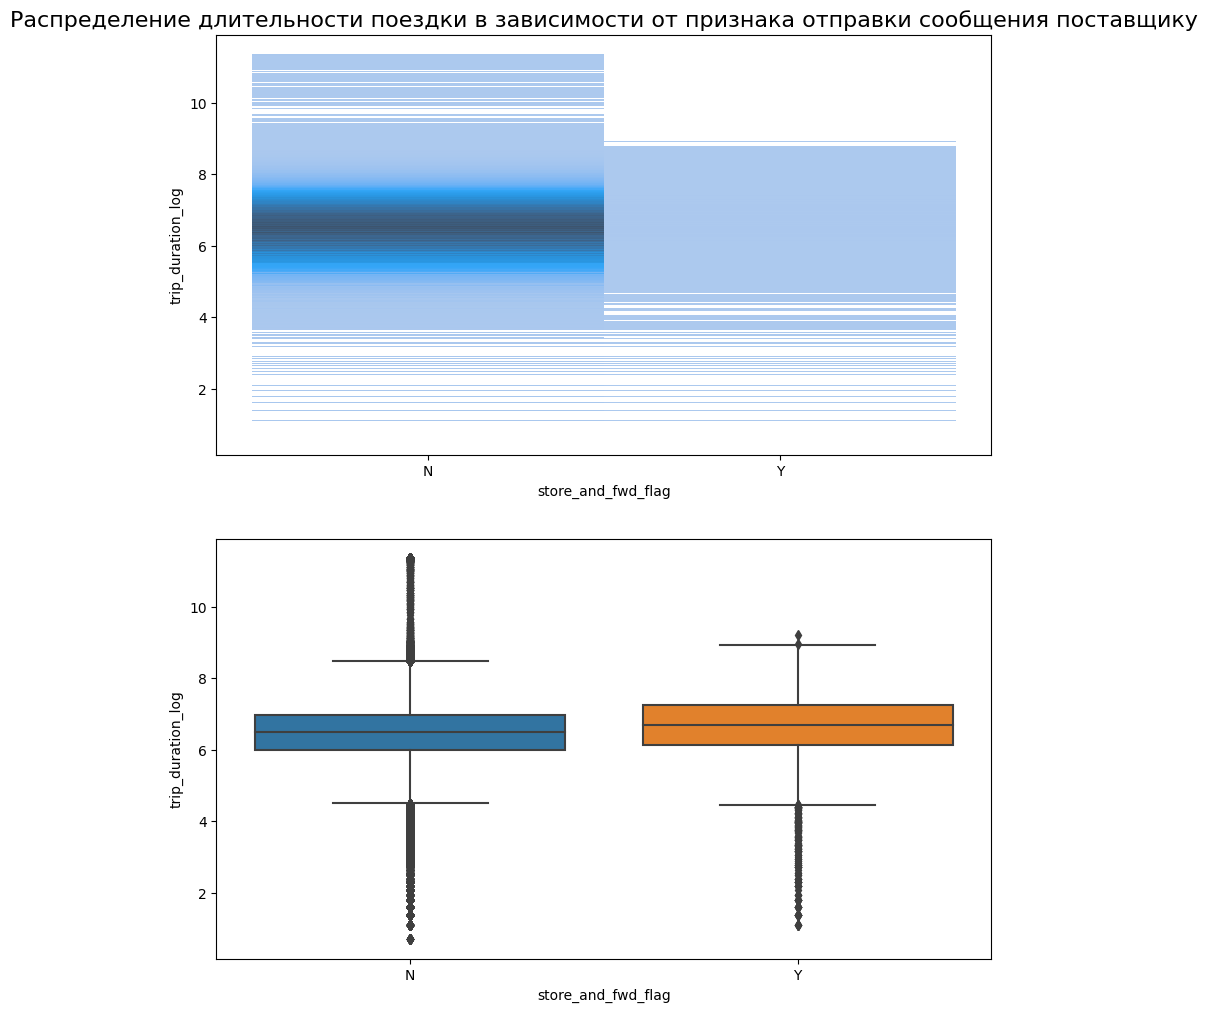

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
histplot = sns.histplot(data=taxi_data, x=taxi_data['store_and_fwd_flag'], y=taxi_data['trip_duration_log'], ax=axes[0]);
histplot.set_title('Распределение длительности поездки в зависимости от признака отправки сообщения поставщику', fontsize = 16);
boxplot = sns.boxplot(data=taxi_data, x=taxi_data['store_and_fwd_flag'], y=taxi_data['trip_duration_log'], ax=axes[1]);

Распределения в группах значительно отличаются, признак store_and_fwd_flag имеет значение при определении длительности поездки.

Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

чтобы выяснить:
* в какое время суток такси заказывают реже всего,
* в какое время суток наблюдается пик медианной длительности поездок.

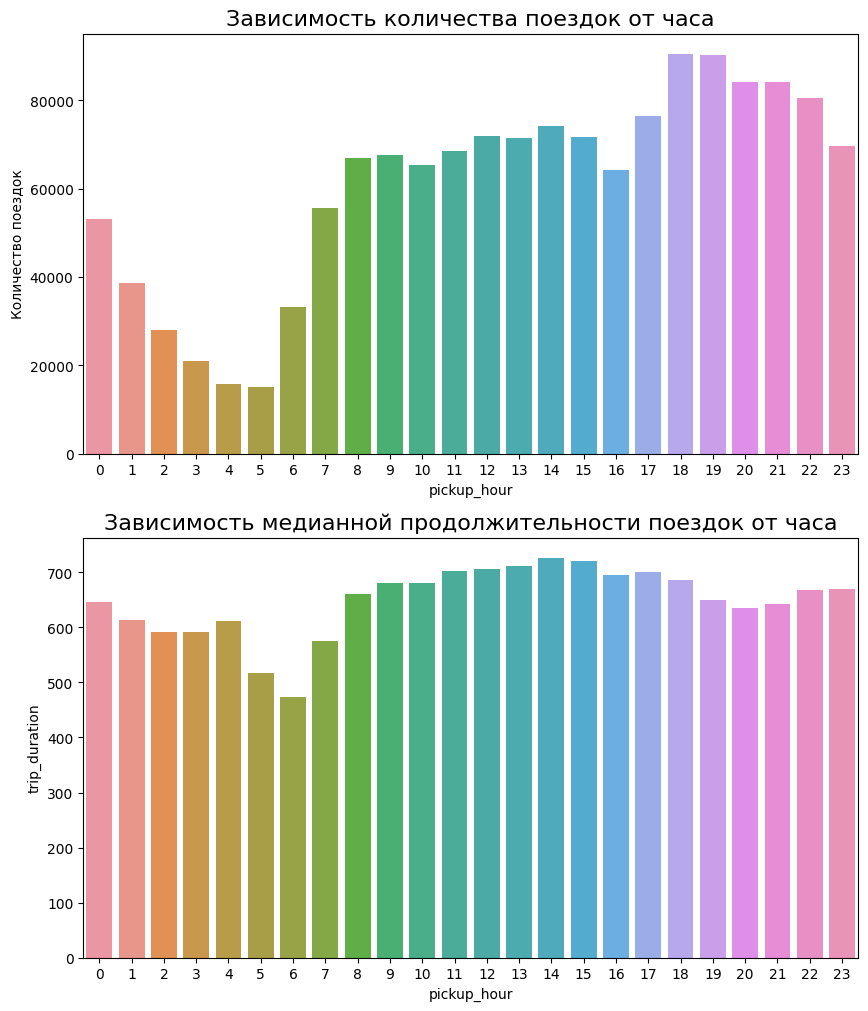

In [38]:
pivot_trip_count = taxi_data.groupby(by='pickup_hour')[['id']].count()

pivot_duration_median = taxi_data.groupby(by='pickup_hour')[['trip_duration']].median()    

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
barplot1 = sns.barplot(
    data=pivot_trip_count, 
    x=pivot_trip_count.index,
    y=pivot_trip_count['id'],
    ax=axes[0],
    );
barplot1.set_title('Зависимость количества поездок от часа', fontsize = 16)
barplot1.set_ylabel('Количество поездок');
barplot2 = sns.barplot(
    data=pivot_duration_median, 
    x=pivot_duration_median.index,
    y=pivot_duration_median['trip_duration'],
    ax=axes[1]
    );
barplot2.set_title('Зависимость медианной продолжительности поездок от часа', fontsize = 16);

Как видно из графиков, чаще всего такси заказывают в период времени от 18 до 22 часов, реже всего - от 1 часа до 6 часа.

Дольше всего поездки длятся в период времени от 13 до 15 часов. Менее всего - от 5 от 7 часов.

Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

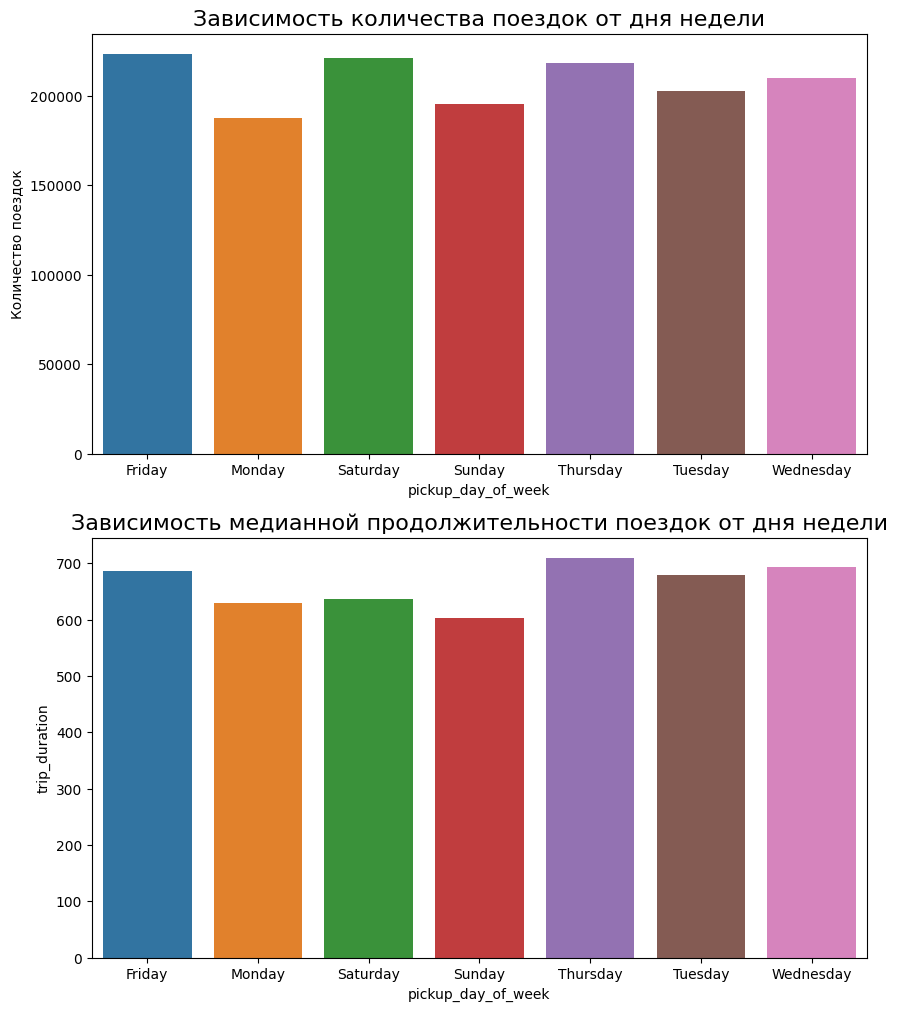

In [39]:
trips_weekdays = taxi_data.groupby(by='pickup_day_of_week')[['id']].count()

duration_weekdays = taxi_data.groupby(by='pickup_day_of_week')[['trip_duration']].median()    

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
barplot1 = sns.barplot(
    data=trips_weekdays, 
    x=trips_weekdays.index,
    y=trips_weekdays['id'],
    ax=axes[0],
    );
barplot1.set_title('Зависимость количества поездок от дня недели', fontsize = 16)
barplot1.set_ylabel('Количество поездок');
barplot2 = sns.barplot(
    data=duration_weekdays, 
    x=duration_weekdays.index,
    y=duration_weekdays['trip_duration'],
    ax=axes[1]
    );
barplot2.set_title('Зависимость медианной продолжительности поездок от дня недели', fontsize = 16);

Как видно из визуализации, чаще всего такси заказывают в пятницу и субботу, реже всего - в понедельник и воскресенье.

Самые продолжительные поездки совершаются в четверг, самые короткие - в воскресенье.

Посмотрим на обе временные характеристики одновременно. 

Построим сводную таблицу, по строкам которой отложим часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируем полученную сводную таблицу с помощью тепловой карты.

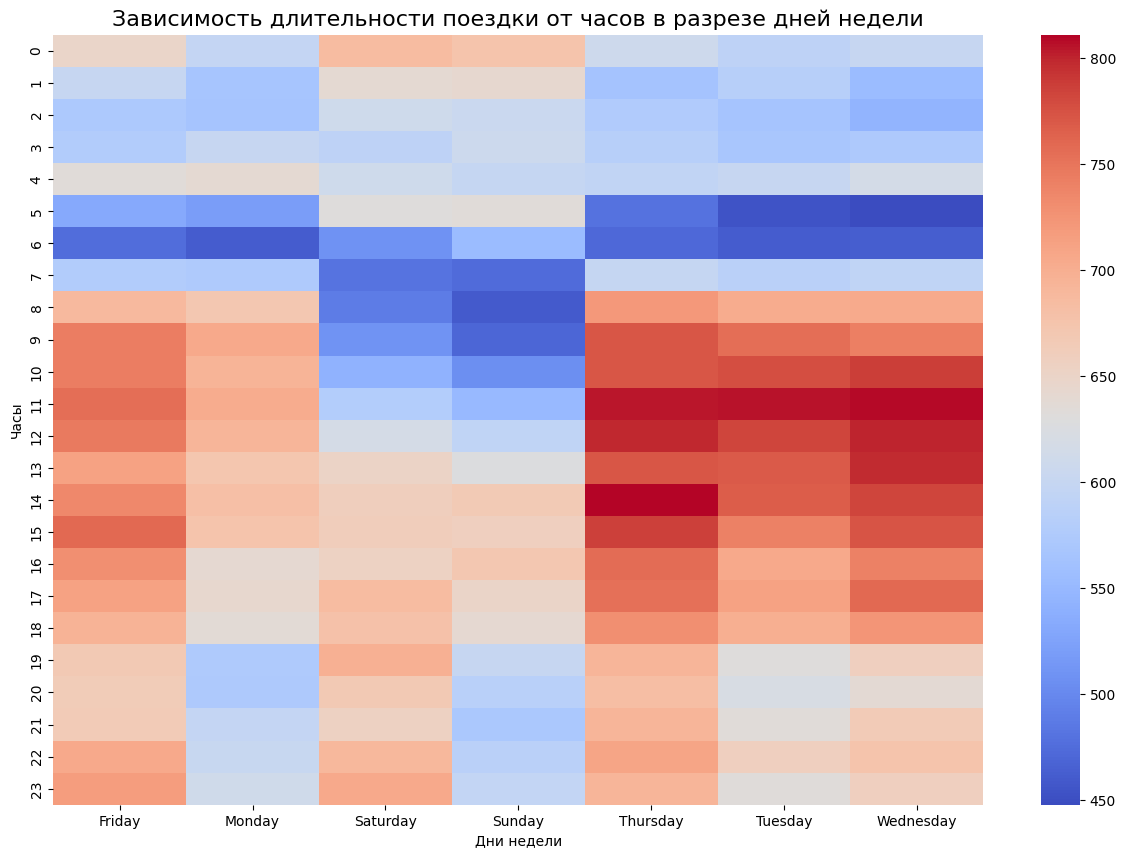

In [40]:
pivot_time = taxi_data.pivot_table( # Создаём сводную таблицу из ch_data_exited, в которой посчитаем количество ушедших клиентов по странам
    values='trip_duration', 
    index='pickup_hour',
    columns='pickup_day_of_week',
    aggfunc='median'
)

fig = plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(data=pivot_time, cmap='coolwarm') # На основе сводной таблицы строим тепловую карту.
heatmap.set_title('Зависимость длительности поездки от часов в разрезе дней недели', fontsize=16)
heatmap.set_xlabel('Дни недели')
heatmap.set_ylabel('Часы');

На данной визуализации видно, что наиболее длительные поездки совершаются во вторник, среду и четверг в период времени с 11 до 14 часов. Самые короткие - в будние дни с 5 до 6 часов.

Построим две диаграммы рассеяния (scatter-диаграммы):
* первая будет иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая будет иллюстрировать географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Включим в визуализацию только те точки, которые находятся в пределах Нью-Йорка:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавим для наглядности на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

C:\Users\Олег\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Олег\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


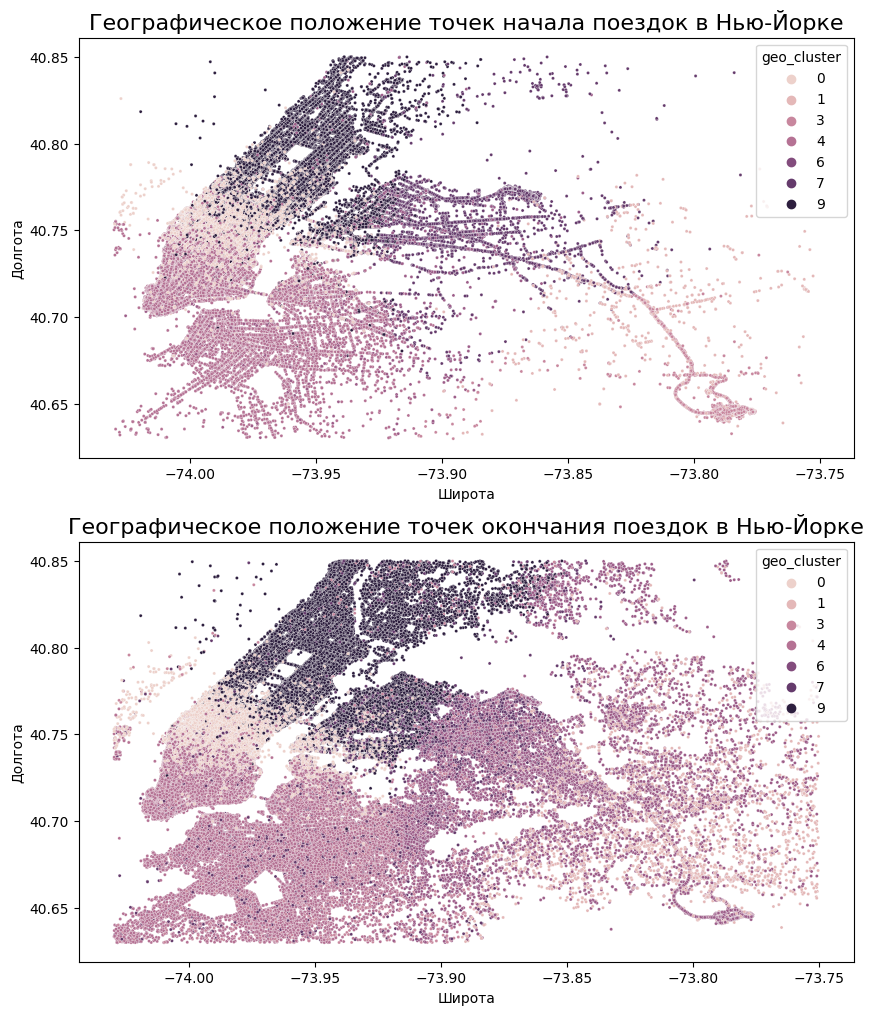

In [41]:
# Переменные с границами Нью-Йорка:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Вносим ограничения для данных в нашем датасете:
mask_long_up = (city_long_border[0] <= taxi_data['pickup_longitude']) & (taxi_data['pickup_longitude'] <= city_long_border[1])
mask_long_off = (city_long_border[0] <= taxi_data['dropoff_longitude']) & (taxi_data['dropoff_longitude'] <= city_long_border[1])
mask_lat_up = (city_lat_border[0] <= taxi_data['pickup_latitude']) & (taxi_data['pickup_latitude'] <= city_lat_border[1])
mask_lat_off = (city_lat_border[0] <= taxi_data['dropoff_latitude']) & (taxi_data['dropoff_latitude'] <= city_lat_border[1])

# Обрезаем таблицу по установленным ограничениям:
new_york = taxi_data[mask_long_up & mask_long_off & mask_lat_up & mask_lat_off]

# Строим диаграмму рассеяния для точек начала поездок:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

scatter1 = sns.scatterplot(
    data=new_york,
    x='pickup_longitude',
    y='pickup_latitude',
    ax=axes[0],
    hue='geo_cluster',
    s=5
    )
scatter1.set_title('Географическое положение точек начала поездок в Нью-Йорке', fontsize=16)
scatter1.set_xlabel('Широта')
scatter1.set_ylabel('Долгота');

# Строим диаграмму рассеяния для точек окончания поездок:
scatter2 = sns.scatterplot(
    data=new_york,
    x='dropoff_longitude',
    y='dropoff_latitude',
    ax=axes[1],
    hue='geo_cluster',
    s=5
    )
scatter2.set_title('Географическое положение точек окончания поездок в Нью-Йорке', fontsize=16)
scatter2.set_xlabel('Широта')
scatter2.set_ylabel('Долгота');

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* закодировать категориальные признаки;
* отобрать признаки, которые мы будем использовать для обучения модели;
* необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.

Для удобства работы сделаем копию исходной таблицы с поездками:

In [43]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


Удалим из набора данных призники 'id' (он не несёт никакой информации о целевой переменной) и 'dropoff_datetime' (он вызывает утечку данных).

In [44]:
train_data.drop(['id', 'dropoff_datetime'], axis=1, inplace=True)
train_data.shape

(1458233, 25)

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [45]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


Закодируем признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируем признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

In [46]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
train_data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day_of_week,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,1,1,-73.982155,40.767937,-73.964630,40.765602,0,455,17,Monday,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,0,1,-73.980415,40.738564,-73.999481,40.731152,0,663,0,Sunday,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,1,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,11,Tuesday,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,1,1,-74.010040,40.719971,-74.012268,40.706718,0,429,19,Wednesday,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,1,1,-73.973053,40.793209,-73.972923,40.782520,0,435,13,Saturday,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


Создадим таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставим в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder мы получим безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем.

In [47]:
from sklearn.preprocessing import OneHotEncoder

data_onehot = train_data[['pickup_day_of_week', 'geo_cluster', 'events']]
one_hot_encoder = OneHotEncoder(drop = 'first').fit(data_onehot)
column_names = one_hot_encoder.get_feature_names_out()
data_onehot = one_hot_encoder.transform(data_onehot).toarray()
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
data_onehot

,pickup_day_of_week_Monday,pickup_day_of_week_Saturday,pickup_day_of_week_Sunday,pickup_day_of_week_Thursday,pickup_day_of_week_Tuesday,pickup_day_of_week_Wednesday,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1458229,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1458230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1458231,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Добавим полученную таблицу с закодированными признаками в исходный набор данных:

In [48]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [49]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [50]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберём 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуем по обучающей выборке, используя параметр score_func = f_regression.

Выведем признаки, которые вошли в список отобранных

In [51]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)
 
selector.get_feature_names_out()

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday',
       'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'temperature', 'pickup_day_of_week_Monday',
       'pickup_day_of_week_Saturday', 'pickup_day_of_week_Sunday',
       'pickup_day_of_week_Thursday', 'pickup_day_of_week_Tuesday',
       'pickup_day_of_week_Wednesday', 'geo_cluster_1', 'geo_cluster_3',
       'geo_cluster_5', 'geo_cluster_7', 'geo_cluster_9'], dtype=object)

In [52]:
# Занесё отобранные признаки в список:
features_list = list(selector.get_feature_names_out())

# Оставим в обучающей и тренировочной выборках только отобранные признаки:
X_train, X_valid = X_train[features_list], X_valid[features_list]
print('Shape of data: {}'.format(X_train.shape))
print('Shape of data: {}'.format(X_valid.shape))

Shape of data: (977016, 25)
Shape of data: (481217, 25)


Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn.

In [53]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
X_train = pd.DataFrame(data=mm_scaler.fit_transform(X_train), columns=features_list)
X_valid = pd.DataFrame(data=mm_scaler.transform(X_valid), columns=features_list)

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

В качестве метрики мы будем использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$

Построим модель линейной регрессии на обучающей выборке и рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [54]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train_log)
y_train_log_pred = lin_reg.predict(X_train)
y_valid_log_pred = lin_reg.predict(X_valid)

print(f'RMSLE на обучающей выборке равна {round((mean_squared_error(y_train_log, y_train_log_pred))**(1/2), 2)}')
print(f'RMSLE на валидационной выборке равна {round((mean_squared_error(y_valid_log, y_valid_log_pred))**(1/2), 2)}')

RMSLE на обучающей выборке равна 0.54
RMSLE на валидационной выборке равна 0.54


Сгенерируем полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn.

Построим модель полиномиальной регрессии 2-ой степени на обучающей выборке и рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [ ]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.fit_transform(X_train)
#Генерируем полиномиальные признаки для валидационной выборки
X_valid_poly = poly.fit_transform(X_valid)

#Создаём объект класса LinearRegression
lr_model_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model_poly.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_log_pred_poly = lr_model_poly.predict(X_train_poly)
#Делаем предсказание для валидационной выборки
y_valid_log_pred_poly = lr_model_poly.predict(X_valid_poly)
 
#Рассчитываем RMSLE для двух выборок
print(f'RMSLE на обучающей выборке равна {round((mean_squared_error(y_train_log, y_train_log_pred_poly))**(1/2), 2)}')
print(f'RMSLE на валидационной выборке равна {round((mean_squared_error(y_valid_log, y_valid_log_pred_poly))**(1/2), 2)}')

Построим модель полиномиальной регрессии 2-ой степени с L2-регуляризацией на обучающей выборке и рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [ ]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=1)
#Обучаем модель
ridge_lr_poly.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_log_pred_ridge = ridge_lr_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_valid_log_pred_ridge = ridge_lr_poly.predict(X_valid_poly)

#Рассчитываем RMSLE для двух выборок
print(f'RMSLE на обучающей выборке равна {round((mean_squared_error(y_train_log, y_train_log_pred_ridge))**(1/2), 2)}')
print(f'RMSLE на валидационной выборке равна {round((mean_squared_error(y_valid_log, y_valid_log_pred_ridge))**(1/2), 2)}')

Построим модель дерева решений (DecisionTreeRegressor) на обучающей выборке и рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [65]:
#Создаём объект класса DecisionTreeClassifier
dt = tree.DecisionTreeRegressor(random_state=42)
#Обучаем дерево решений по алгоритму CART
dt.fit(X_train, y_train_log)

y_train_log_pred_dt = dt.predict(X_train)
y_valid_log_pred_dt = dt.predict(X_valid)

#Рассчитываем RMSLE для двух выборок
print(f'RMSLE на обучающей выборке равна {round((mean_squared_error(y_train_log, y_train_log_pred_dt))**(1/2), 2)}')
print(f'RMSLE на валидационной выборке равна {round((mean_squared_error(y_valid_log, y_valid_log_pred_dt))**(1/2), 2)}')

RMSLE на обучающей выборке равна 0.0
RMSLE на валидационной выборке равна 0.57


Как видим, наблюдается переобучение модели.

Переберём все возможные варианты глубины дерева решений в диапазоне от 7 до 20 для того, чтобы выявить наиболее оптимальный параметр. Для визуализации процесса поиска оптимального параметра построим графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

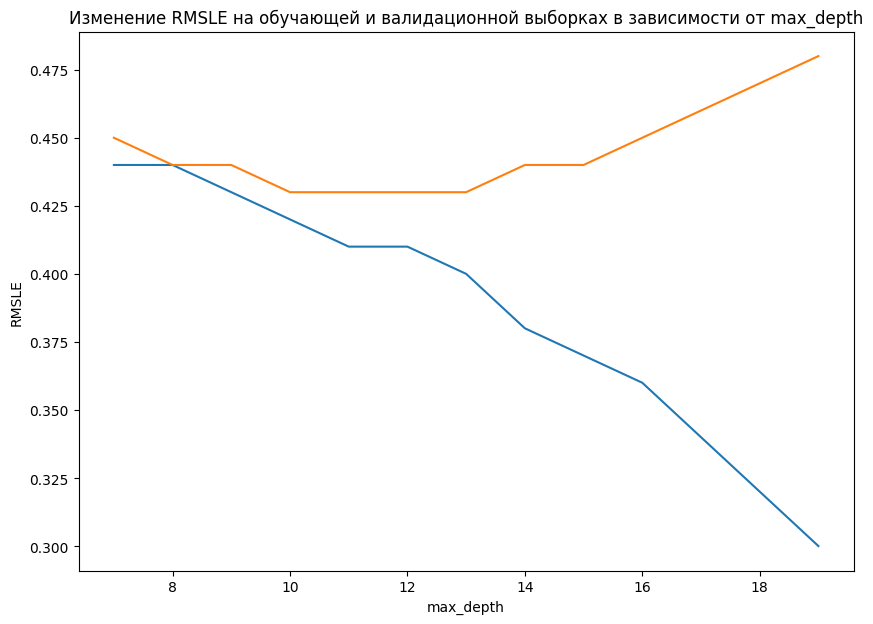

In [56]:
# Создаём пустой словарь, в который будем заносить значения метрики RMSLE:
rmsle_values = {'max_depth': [], 'RMSLE на обучающей выборке': [], 'RMSLE на валидационной выборке': []}
i = 7

# Создаём цикл, в котором будем перебирать различные значения max_depth
while i in range(7, 20):
    # Строим дерево решений
    dt = tree.DecisionTreeRegressor(max_depth = i, random_state=42)
    dt.fit(X_train, y_train_log)
    # Делаем предсказания на тренировочной и валидационной выборках:
    y_train_log_pred_dt = dt.predict(X_train)
    y_valid_log_pred_dt = dt.predict(X_valid)
    # Считаем RMSLE:
    rmsle_train = round((mean_squared_error(y_train_log, y_train_log_pred_dt))**(1/2), 2)
    rmsle_valid = round((mean_squared_error(y_valid_log, y_valid_log_pred_dt))**(1/2), 2)
    # Заполняем словарь
    rmsle_values['max_depth'].append(i) 
    rmsle_values['RMSLE на обучающей выборке'].append(rmsle_train)
    rmsle_values['RMSLE на валидационной выборке'].append(rmsle_valid)
    i += 1

# Преобразуем словарь в дата-фрейм для удобства визуализации:    
rmsle_values_df = pd.DataFrame(rmsle_values)

# Строим графики:
fig = plt.figure(figsize=(10, 7))
lineplot1 = sns.lineplot(data=rmsle_values_df, x='max_depth', y='RMSLE на обучающей выборке', legend='brief')
lineplot2 = sns.lineplot(data=rmsle_values_df, x='max_depth', y='RMSLE на валидационной выборке', legend='brief')
lineplot1.set_xlabel('max_depth')
lineplot1.set_ylabel('RMSLE')
lineplot1.set_title('Изменение RMSLE на обучающей и валидационной выборках в зависимости от max_depth');

Как видим, оптимальной глубиной дерева решений является 12: далее графики начинают сильно расходиться, что свидетельствует о переобучении модели.

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Построим модель случайного леса на обучающей выборке и рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [57]:
from sklearn.ensemble import RandomForestRegressor

# Создаем модель случайного леса
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    verbose=True
)

# Обучаем модель
rf.fit(X_train, y_train_log)

y_train_log_pred_rf = rf.predict(X_train)
y_valid_log_pred_rf = rf.predict(X_valid)

#Рассчитываем RMSLE для двух выборок
print(f'RMSLE на обучающей выборке равна {round((mean_squared_error(y_train_log, y_train_log_pred_rf))**(1/2), 2)}')
print(f'RMSLE на валидационной выборке равна {round((mean_squared_error(y_valid_log, y_valid_log_pred_rf))**(1/2), 2)}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 48.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   37.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RMSLE на обучающей выборке равна 0.4
RMSLE на валидационной выборке равна 0.41


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.2s finished


Как видим, метрика RMSLE значительно улучшилась. Кроме того, мы избавилимь от переобучения модели.

Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке и рассчитаем метрику RMSLE на тренировочной и валидационной выборках.

In [73]:
from sklearn.ensemble import GradientBoostingRegressor

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6, 
    min_samples_split=30,
    random_state=42
)

# Обучаем модель
gb.fit(X_train, y_train_log)

y_train_log_pred_gb = gb.predict(X_train)
y_valid_log_pred_gb = gb.predict(X_valid)

#Рассчитываем RMSLE для двух выборок
print(f'RMSLE на обучающей выборке равна {round((mean_squared_error(y_train_log, y_train_log_pred_gb))**(1/2), 2)}')
print(f'RMSLE на валидационной выборке равна {round((mean_squared_error(y_valid_log, y_valid_log_pred_gb))**(1/2), 2)}')

RMSLE на обучающей выборке равна 0.37
RMSLE на валидационной выборке равна 0.39


Метрика стала ещё лучше. Можно констатировать, что градиентный бустинг показывает более хорошие результаты по сравнению со случайным лесом.

Построим столбчатую диаграмму коэффициентов значимости каждого из факторов.

<AxesSubplot: >

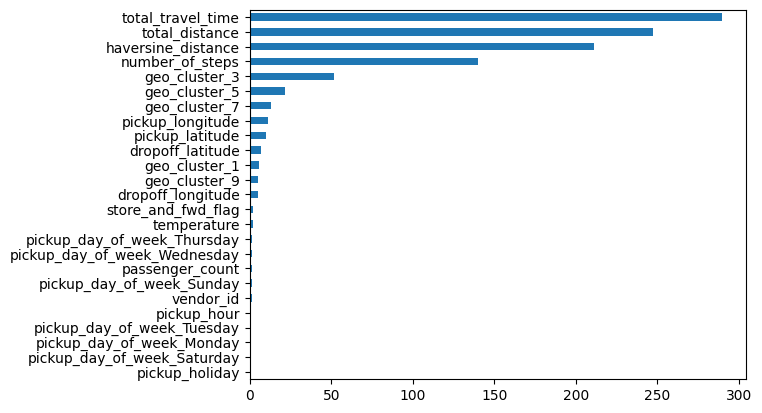

In [63]:
from sklearn.feature_selection import f_classif

features = X_train.columns
# Применим к ним функцию f_classif:
imp_num = pd.Series(f_classif(X_train, y_train_log)[0], index=features)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

По диаграмме видно, что наиболее значимыми признаками в нашей модели являются 'total_travel_time', 'total_distance', 'haversine_distance' и 'number_of_steps'.

К сожалению, метрику RMSLE сложно интерпретировать. Чтобы было понятно, насколько точна наша модель, рассчитаем медианную абсолютную ошибку предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

In [74]:
from sklearn.metrics import median_absolute_error

y = np.exp(y_valid_log) - 1
y_pred = np.exp(y_valid_log_pred_gb) - 1

print(f'Медианная абсолютная ошибка на валидационной выборке равна {round((median_absolute_error(y, y_pred)) / 60, 1)} мин.')

Медианная абсолютная ошибка на валидационной выборке равна 1.8 мин.


Итак, медианная ошибка нашей модеои составляем 1 мин. 48 сек.

Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных.

In [136]:
test_data = pd.read_csv("F:\IDE\SkillFactory\Проекты\Project-5\Project5_test_data.csv")
osrm_data_test = pd.read_csv("F:\IDE\SkillFactory\Проекты\Project-5\Project5_osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки произведём все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Переведём признак pickup_datetime в формат datetime;
* Добавим новые признаки (временные, географические, погодные и другие факторы);
* Произведём очистку данных от пропусков;
* Произведём кодировку категориальных признаков:
    * Закодируем бинарные признаки;
    * Закодируем номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформируем матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализуем данные с помощью обученного на тренировочной выборке MinMaxScaler’а.

In [138]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[features_list]
X_test_scaled = mm_scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

c:\Users\Олег\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Олег\AppData\Local\Temp\ipykernel_972\993725282.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['pickup_date'] = pd.to_datetime(df2['date']).dt.date
C:\Users\Олег\AppData\Local\Temp\ipykernel_972\993725282.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Shape of data: (625134, 25)


Делаем предсказание длительности поездки для тестовой выборки.

In [139]:
# Делаем предсказание для логарифмированных признаков:
y_test_predict_log = gb.predict(X_test_scaled)

# Потенцируем:
y_test_predict = np.exp(y_test_predict_log) - 1

# Делаем submission:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('F:\IDE\SkillFactory\Проекты\Project-5\submission_gb.csv', index=False)

c:\Users\Олег\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Попробуем улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

In [142]:
import xgboost as xgb

# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=features_list)
dvalid = xgb.DMatrix(X_valid, label=y_valid_log, feature_names=features_list)
dtest = xgb.DMatrix(X_test_scaled, feature_names=features_list)

In [144]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.73992	valid-rmse:0.74194
[10]	train-rmse:0.49093	valid-rmse:0.49351
[20]	train-rmse:0.44059	valid-rmse:0.44344
[30]	train-rmse:0.42595	valid-rmse:0.42899
[40]	train-rmse:0.41826	valid-rmse:0.42145
[50]	train-rmse:0.41278	valid-rmse:0.41628
[60]	train-rmse:0.40921	valid-rmse:0.41297
[70]	train-rmse:0.40578	valid-rmse:0.40984
[80]	train-rmse:0.40266	valid-rmse:0.40697
[90]	train-rmse:0.40070	valid-rmse:0.40529
[100]	train-rmse:0.39897	valid-rmse:0.40397
[110]	train-rmse:0.39740	valid-rmse:0.40265
[120]	train-rmse:0.39626	valid-rmse:0.40178
[130]	train-rmse:0.39502	valid-rmse:0.40086
[140]	train-rmse:0.39424	valid-rmse:0.40034
[150]	train-rmse:0.39301	valid-rmse:0.39936
[160]	train-rmse:0.39220	valid-rmse:0.39888
[170]	train-rmse:0.39146	valid-rmse:0.39832
[180]	train-rmse:0.39072	valid-rmse:0.39789
[190]	train-rmse:0.39009	valid-rmse:0.39756
[200]	train-rmse:0.38924	valid-rmse:0.39706
[210]	train-rmse:0.38877	valid-rmse:0.39680
[220]	train-rmse:0.38794	valid-rmse:0.39626

Предскажем целевой признак на новых данных.

In [145]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39412


Визуализируем важность факторов.

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

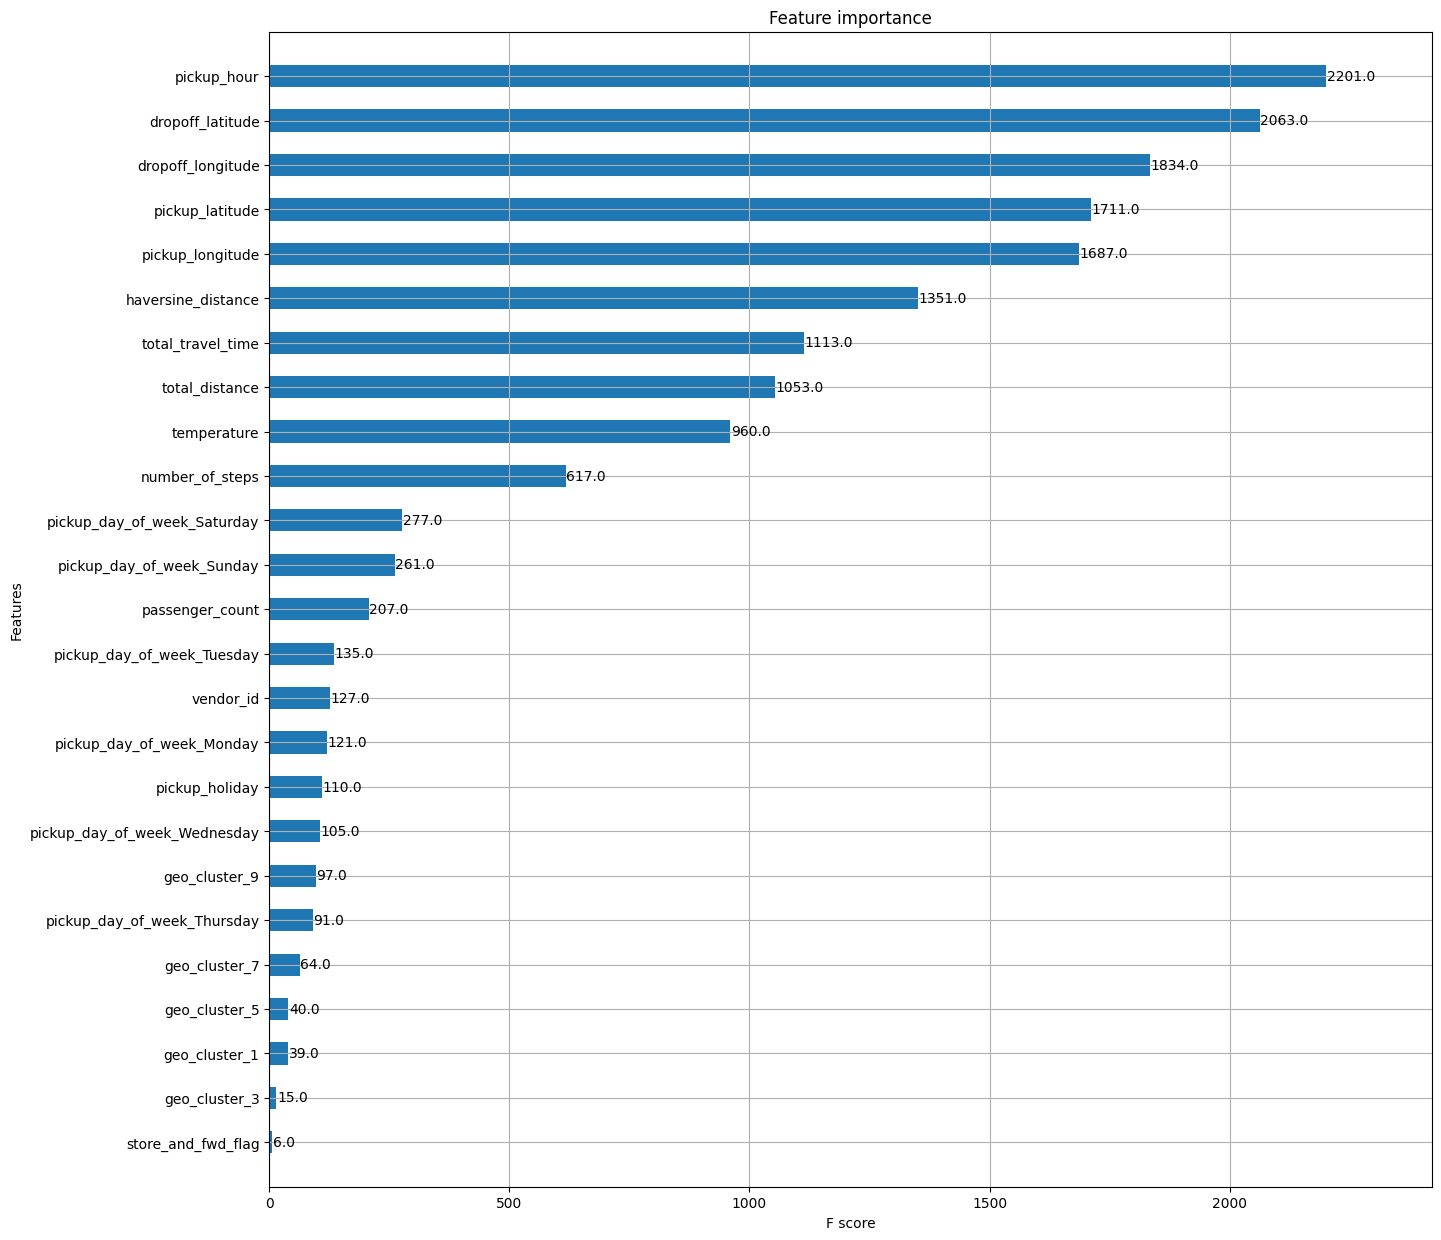

In [146]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)

In [147]:
# Делаем submission
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('F:\IDE\SkillFactory\Проекты\Project-5\submission_gb_new.csv', index=False)